In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import quimb as qu
import quimb.tensor as qtn
import cotengra as ctg

opt = ctg.ReusableHyperOptimizer(
    reconf_opts={},
    max_repeats=16,
    parallel=True,
)

/home/ampolloreno/repos/cotengra/cotengra/hyper.py:29: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


In [3]:
from scipy.optimize import dual_annealing
from classical_optimization.qaoa_circuits import execute_qaoa_circuit_and_estimate_cost
import numpy as np
from qiskit import Aer, execute
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model
import networkx as nx

np.random.seed(666)
reprate = 25 
one_hour = 60 * 60 #seconds
max_gamma = 2 * np.pi
max_beta = np.pi

n = 20
m = int(n/2)
edges = []
while len(edges) < m:
    edge = (np.random.randint(n), np.random.randint(n))
    if edge not in edges and (edge[1], edge[0]) not in edges and edge[0] != edge[1]:
        
        edges.append(edge)
weights = {edge:((np.random.rand(1)-.5)*2)[0] for edge in edges}
positive_edges = [edge for edge in edges if weights[edge]>0]
#weights = {edge:1 for edge in edges}
graph=nx.Graph()
graph.add_weighted_edges_from([(edge[0], edge[1], weights[edge]) for edge in edges])


terms = weights
circ_ex = None
BASELINE_SHOTS = 5
def weights(graph):
    rtn = {}
    for e in graph.edges:
        weight = graph.get_edge_data(e[0], e[1])['weight']
        rtn[e] = weight
    return rtn

def objective(graph):
    #Hack for backwards compatibility.
    num_rows = len(graph.nodes)
    num_cols = 1

    history = []
    def store_log(func):
        def logged_func(x):
            ret = func(x)
            history.append((x, ret))
            return ret
        return logged_func

    @store_log
    def gamma_beta_objective(gamma_beta):
        p=1
        gammas = [gamma_beta[1]]
        betas = [gamma_beta[0]]
        circ_ex = qtn.circ_qaoa(terms, p, gammas, betas)
        circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
        ZZ = qu.pauli('Z') & qu.pauli('Z')
#         ens = [
#             circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
#             for edge, weight in terms.items()
#         ]
            
#         return sum(ens).real
        samples = list(circ_ex.simulate_counts(shots_per_point))
        values = []
        for sample in samples:
            value = 0
            for k, v in terms.items():
                if sample[k[0]] != sample[k[1]]:
                    value += 1
            values.append(value)
        return np.mean(values)
    return gamma_beta_objective, history

def expectation_objective(graph):
    #Hack for backwards compatibility.
    num_rows = len(graph.nodes)
    num_cols = 1

    history = []
    def store_log(func):
        def logged_func(x):
            ret = func(x)
            history.append((x, ret))
            return ret
        return logged_func

    @store_log
    def gamma_beta_objective(gamma_beta):
        p=1
        gammas = [gamma_beta[1]]
        betas = [gamma_beta[0]]
        circ_ex = qtn.circ_qaoa(terms, p, gammas, betas)
        circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
        ZZ = qu.pauli('Z') & qu.pauli('Z')
        ens = [
            circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
            for edge, weight in terms.items()
        ]
            
        return sum(ens).real
    return gamma_beta_objective, history



/home/ampolloreno/anaconda3/envs/qaoa/lib/python3.8/site-packages/qiskit/validation/fields/custom.py:76: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpy.integer, numpy.float,
/home/ampolloreno/anaconda3/envs/qaoa/lib/python3.8/site-packages/qiskit/quantum_info/operators/pauli.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  z = np.zer

In [4]:
gammas = [1]
betas = [1]
p=1
# global circ_ex
# if circ_ex is None:
circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
# else:
#     new_circ_ex = qtn.circuit_gen.circ_qaoa(terms, p, gammas, betas)
#     tm = new_circ_ex.to_dense_tn()
#     circ_ex.update_params_from(tm)
ZZ = qu.pauli('Z') & qu.pauli('Z')
ens = [
    circ_ex.local_expectation(weight * ZZ, edge, optimize=opt)
    for edge, weight in terms.items()
]

In [5]:
import networkx as nx
obj, hist = expectation_objective(graph)
all_data = []
bound = np.pi
samples = 20
for g in list(reversed(np.linspace(0, bound, num=samples))):
    data = []
    print(g)
    for b in np.linspace(0, bound, num=samples):
        data.append(obj([b, g]))
    all_data.append(data)

3.141592653589793
2.9762456718219092
2.8108986900540254
2.6455517082861415
2.4802047265182576
2.3148577447503738
2.14951076298249
1.984163781214606
1.8188167994467224
1.6534698176788385
1.4881228359109546
1.3227758541430708
1.1574288723751869
0.992081890607303
0.8267349088394192
0.6613879270715354
0.4960409453036515
0.3306939635357677
0.16534698176788384
0.0


(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]), [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])


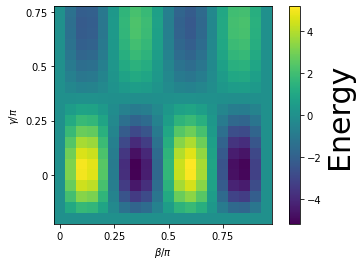

In [6]:
import matplotlib.pyplot as plt
plt.imshow(np.array(all_data))
plt.ylabel(r"$\gamma/\pi$")
plt.xlabel(r"$\beta/\pi$")
print(plt.xticks())
plt.xticks(plt.xticks()[0][1:-1:2], [0, .25, .5, .75])
plt.yticks(plt.yticks()[0][1:-1:2], [0, .25, .5, .75][::-1])
cb = plt.colorbar()
cb.set_label('Energy', fontsize=30)

In [7]:
from es import SimpleGA, CMAES, PEPG, OpenES
NPARAMS = 2
NPOPULATION = 10
oes = OpenES(NPARAMS,                  # number of model parameters
            sigma_init=0.025*np.pi*5,            # initial standard deviation
            sigma_decay=1,         # don't anneal standard deviation
            learning_rate=0.005,         # learning rate for standard deviation
            learning_rate_decay = 0.0, # annealing the learning rate
            popsize=NPOPULATION,       # population size
            antithetic=False,          # whether to use antithetic sampling
            weight_decay=0.00,         # weight decay coefficient
            rank_fitness=False,        # use rank rather than fitness numbers
            forget_best=True)

In [21]:
from tqdm import tqdm
MAX_ITERATION = 30
shots_per_point = BASELINE_SHOTS
fit_func1, history = objective(graph)
fit_func = lambda x: fit_func1(x)
# defines a function to use solver to solve fit_func
def test_solver(solver):
    history = []
    for j in tqdm(range(MAX_ITERATION)):
        solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)
        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        print(result)
        history.append((result))
        if (j+1) % 100 == 0:
            print("fitness at iteration", (j+1), result[1])
    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return history, result

In [22]:
history, result = test_solver(oes)


  3%|▎         | 1/30 [00:00<00:16,  1.79it/s]

(array([ 0.36692144, -0.11555666]), 5.8, 5.8, 0.39269908169872414)


  7%|▋         | 2/30 [00:01<00:15,  1.78it/s]

(array([-0.37606862, -0.25823695]), 6.2, 6.2, 0.39269908169872414)


 10%|█         | 3/30 [00:01<00:15,  1.79it/s]

(array([-0.34759314, -0.71136581]), 6.8, 6.8, 0.39269908169872414)


 13%|█▎        | 4/30 [00:02<00:14,  1.78it/s]

(array([0.35659894, 0.20887882]), 5.8, 5.8, 0.39269908169872414)


 17%|█▋        | 5/30 [00:02<00:13,  1.79it/s]

(array([-0.84580573,  0.10792665]), 6.0, 6.0, 0.39269908169872414)


 20%|██        | 6/30 [00:03<00:13,  1.79it/s]

(array([-0.39484752, -0.08622665]), 6.2, 6.2, 0.39269908169872414)


 23%|██▎       | 7/30 [00:04<00:13,  1.70it/s]

(array([0.36365651, 0.72081574]), 7.2, 7.2, 0.39269908169872414)


 27%|██▋       | 8/30 [00:04<00:12,  1.74it/s]

(array([0.38867171, 0.19239905]), 7.0, 7.0, 0.39269908169872414)


 30%|███       | 9/30 [00:05<00:11,  1.76it/s]

(array([-0.37566944, -0.61966097]), 7.0, 7.0, 0.39269908169872414)


 33%|███▎      | 10/30 [00:05<00:11,  1.78it/s]

(array([-0.45892868, -0.89041822]), 6.8, 6.8, 0.39269908169872414)


 37%|███▋      | 11/30 [00:06<00:10,  1.79it/s]

(array([0.21227802, 0.11429556]), 5.8, 5.8, 0.39269908169872414)


 40%|████      | 12/30 [00:06<00:09,  1.80it/s]

(array([0.58645729, 0.20439834]), 6.4, 6.4, 0.39269908169872414)


 43%|████▎     | 13/30 [00:07<00:09,  1.81it/s]

(array([-0.23010326, -0.02861082]), 6.6, 6.6, 0.39269908169872414)


 47%|████▋     | 14/30 [00:07<00:08,  1.80it/s]

(array([0.39044235, 0.52691973]), 6.2, 6.2, 0.39269908169872414)


 50%|█████     | 15/30 [00:08<00:08,  1.81it/s]

(array([-0.15911087, -0.029505  ]), 6.0, 6.0, 0.39269908169872414)


 53%|█████▎    | 16/30 [00:08<00:07,  1.79it/s]

(array([0.0154776 , 0.40653397]), 6.6, 6.6, 0.39269908169872414)


 57%|█████▋    | 17/30 [00:09<00:07,  1.80it/s]

(array([ 0.14874597, -0.18052257]), 6.4, 6.4, 0.39269908169872414)


 60%|██████    | 18/30 [00:10<00:06,  1.81it/s]

(array([ 0.1348927 , -0.38880566]), 6.0, 6.0, 0.39269908169872414)


 63%|██████▎   | 19/30 [00:10<00:06,  1.82it/s]

(array([-0.5761051 , -0.85691062]), 6.4, 6.4, 0.39269908169872414)


 67%|██████▋   | 20/30 [00:11<00:05,  1.82it/s]

(array([-0.35406232, -0.35682407]), 6.2, 6.2, 0.39269908169872414)


 70%|███████   | 21/30 [00:11<00:04,  1.82it/s]

(array([-0.27705184, -0.19176458]), 6.6, 6.6, 0.39269908169872414)


 73%|███████▎  | 22/30 [00:12<00:04,  1.82it/s]

(array([0.3714699 , 0.23926703]), 5.8, 5.8, 0.39269908169872414)


 77%|███████▋  | 23/30 [00:12<00:03,  1.82it/s]

(array([-0.34562869, -0.23255575]), 6.2, 6.2, 0.39269908169872414)


 80%|████████  | 24/30 [00:13<00:03,  1.83it/s]

(array([ 0.06965157, -0.04209641]), 6.2, 6.2, 0.39269908169872414)


 83%|████████▎ | 25/30 [00:13<00:02,  1.83it/s]

(array([0.59501116, 0.14352153]), 7.4, 7.4, 0.39269908169872414)


 87%|████████▋ | 26/30 [00:14<00:02,  1.83it/s]

(array([0.53653276, 0.034664  ]), 6.2, 6.2, 0.39269908169872414)


 90%|█████████ | 27/30 [00:15<00:01,  1.82it/s]

(array([-0.48497612, -0.09569316]), 6.2, 6.2, 0.39269908169872414)


 93%|█████████▎| 28/30 [00:15<00:01,  1.82it/s]

(array([0.2065496 , 0.35515047]), 6.4, 6.4, 0.39269908169872414)


 97%|█████████▋| 29/30 [00:16<00:00,  1.82it/s]

(array([0.07891979, 0.88055225]), 7.2, 7.2, 0.39269908169872414)


100%|██████████| 30/30 [00:16<00:00,  1.80it/s]

(array([-0.8941538 ,  0.39102285]), 6.0, 6.0, 0.39269908169872414)
local optimum discovered by solver:
 [-0.8941538   0.39102285]
fitness score at this local optimum: 6.0


(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]), [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])


([<matplotlib.axis.YTick at 0x7f9a212a7430>,
 [Text(0, 0.0, '0.75'),
  Text(0, 5.0, '0.5'),
  Text(0, 10.0, '0.25'),
  Text(0, 15.0, '0')])

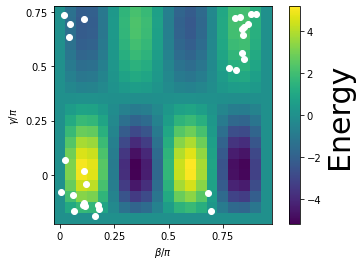

In [26]:
plt.imshow(all_data)
cb = plt.colorbar()
cb.set_label('Energy', fontsize=30)
xys = [h[0] for h in history]
x = [el[0]%(bound)*(samples-1)/(bound) for el in xys]
y = [(bound - (el[1])%(bound))*(samples-1)/(bound) for el in xys]
plt.scatter(x, y, c='w')
plt.ylabel(r"$\gamma/\pi$")
plt.xlabel(r"$\beta/\pi$")
print(plt.xticks())
plt.xticks(plt.xticks()[0][1:-1:2], [0, .25, .5, .75])
plt.yticks(plt.yticks()[0][1:-1:2], [0, .25, .5, .75][::-1])

# Annealing

In [13]:
shots_per_point = NPOPULATION*BASELINE_SHOTS
from tqdm import tqdm
annealing_attempts = []
func, history2 = objective(graph)
seed = 1
np.random.seed(seed)
initial_gamma_beta = [np.random.rand() * max_param for max_param in (max_gamma, max_beta)]
result = dual_annealing(
    lambda x: -1*func(x),
    bounds=[(0, max_gamma),
            (0, max_beta)],
    x0=np.array(initial_gamma_beta),
    # One annealing attempt.
    maxiter=5,
    maxfun=one_hour*reprate,
    seed=1)
result.fun = -result.fun
(result.x, result.fun)        

(array([0.33005245, 1.09205207]), 6.2)

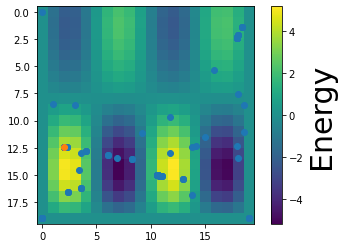

In [14]:
xys2 = [h[0] for h in history2]
x2 = [el[0]%(bound)*(samples-1)/(bound) for el in xys2]
y2 = [(bound - (el[1])%(bound))*(samples-1)/(bound) for el in xys2]
plt.scatter(x2,y2)
plt.scatter([result.x[0]%(bound)*(samples-1)/(bound)], [(bound - (result.x[1]%(bound)))*(samples-1)/(bound)])
plt.imshow(all_data)
cb = plt.colorbar()
cb.set_label('Energy', fontsize=30)

In [20]:
len(x2)/10

26.7